In [21]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

%matplotlib inline

import os, glob
import numpy as np
import pandas as pd
from time import sleep
import gc
import shutil

import ipyparallel as parallel


In [22]:
%version_information ipyparallel,pandas,numpy

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
IPython 5.3.0
OS Darwin 16.5.0 x86_64 i386 64bit
ipyparallel 6.0.2
pandas 0.19.2
numpy 1.11.3
Mon Apr 17 22:35:08 2017 CEST

## Data

Random. This is a demo.  

In [23]:
df_data = pd.DataFrame(data=np.random.randint(low=0, high=1000, size=int(1e4)))
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
0    10000 non-null int64
dtypes: int64(1)
memory usage: 78.2 KB


## Computation
Imagine want to run a long operation on chunks of 100 elemnents of the list.  
In this example we will just calculate the average of the 100 elements and impose a fixed wait in the function.  
There are 100 such chunks in the data above. So it would take 100 x function time if done in sequence. 

In [24]:
compute_time = 0.2

def compute(chunk):
    a = np.mean(chunk)
    sleep(compute_time)
    return a

data = df_data.values.T[0]
chunks = np.split(data, 100)
print('data has {} elements, and was split in {} elements each of size {}'.format(len(data), len(chunks), len(chunks[0])))
print('expected compute time= {} s'.format(compute_time*len(chunks)))

data has 10000 elements, and was split in 100 elements each of size 100
expected compute time= 20.0 s


In [25]:
%%time

result = [compute(c) for c in chunks]
print('result has {} elements from {} to {}'.format(len(result), min(result), max(result)))

result has 100 elements from 427.78 to 575.28
CPU times: user 14.5 ms, sys: 3.15 ms, total: 17.7 ms
Wall time: 20.3 s


## Go parallel

Now if you have several cores available on your or other machines, you can parallel the computation.  
Hopefully the compute time will by the number of cores.  
Let's do it !

## Create Cluster
+ Make sure main and remote machines have access to shared directory on disk - where controller writes cluster info.
+ Copy/paste following commands in terminal
  + Start controller on main machine
  + Start engines on main machine
  + Start engines on remote machine(s)
  

In [26]:
ipython_dir = '/Users/Olivier/Dropbox/Archives/Temp/Parallel'
cluster_id = 'my_cluster'

print('Shared directory ={}'.format(ipython_dir))

print('\nType the commands below in the relevant machines terminal in the following order.')

print('\nCopy/paste following command in local machine to start controller:')
print('Or simpler launch script `launch_controller.sh` on local machine')
cmd = 'ipcontroller --ip=* --ipython-dir={} --cluster-id={}'.format(ipython_dir, cluster_id)
print(cmd)
with open(os.path.join(ipython_dir, 'launch_controller.sh'), 'wb') as f:
    f.write(cmd.encode('utf-8'))

print('\nCopy/paste following command in local machine to start engines (for nb engines = 3 = nb cores -1):')
print('Or simpler launch script `launch_engines_local.sh` on local machine')
cmd = 'ipcluster engines -n 3 --ipython-dir={} --cluster-id={}'.format(ipython_dir, cluster_id)
print(cmd)
with open(os.path.join(ipython_dir, 'launch_engines_local.sh'), 'wb') as f:
    f.write(cmd.encode('utf-8'))

print('\nCopy/paste following command in remote machine(s) to start engines (for nb engines = 4 = nb cores):')
print('Or simpler launch script `launch_engines_remote.sh` on remote machine')
cmd = 'ipcluster engines -n 4 --ipython-dir={} --cluster-id={}'.format(ipython_dir, cluster_id)
print(cmd)
with open(os.path.join(ipython_dir, 'launch_engines_remote.sh'), 'wb') as f:
    f.write(cmd.encode('utf-8'))

client_file = ipython_dir+'/profile_default/security/ipcontroller-'+cluster_id+'-client.json'
engine_file = ipython_dir+'/profile_default/security/ipcontroller-'+cluster_id+'-engine.json'
print('\nTo check the cluster info you can check the following files:')
print('Client file:\n{}'.format(client_file))
print('Engine file:\n{}'.format(engine_file))


Shared directory =/Users/Olivier/Dropbox/Archives/Temp/Parallel

Type the commands below in the relevant machines terminal in the following order.

Copy/paste following command in local machine to start controller:
Or simpler launch script `launch_controller.sh` on local machine
ipcontroller --ip=* --ipython-dir=/Users/Olivier/Dropbox/Archives/Temp/Parallel --cluster-id=my_cluster

Copy/paste following command in local machine to start engines (for nb engines = 3 = nb cores -1):
Or simpler launch script `launch_engines_local.sh` on local machine
ipcluster engines -n 3 --ipython-dir=/Users/Olivier/Dropbox/Archives/Temp/Parallel --cluster-id=my_cluster

Copy/paste following command in remote machine(s) to start engines (for nb engines = 4 = nb cores):
Or simpler launch script `launch_engines_remote.sh` on remote machine
ipcluster engines -n 4 --ipython-dir=/Users/Olivier/Dropbox/Archives/Temp/Parallel --cluster-id=my_cluster

To check the cluster info you can check the following files:
C

## Init Parallel
+ `rc.ids` shows the numbers of engines available to the controller


In [27]:
# rc.close()
rc = parallel.Client(client_file)
dv = rc[:] # direct view
lbv = rc.load_balanced_view() # load balanced view

print(rc.ids)
print(lbv.block)

[0, 1, 2, 3, 4, 5, 6]
False


#### Reset Engines

In [28]:
# rc.purge_everything()
# rc.purge_hub_results(jobs=[], targets=[])
# rc.purge_results(jobs=[], targets=[])
# rc.abort(jobs=None, targets=None, block=None)

## Shared Imports
+ `%%px --local` executes on engines and kernel


In [29]:
%%px --local

import warnings
warnings.filterwarnings("ignore", module="matplotlib")

import os
import numpy as np
import pandas as pd
from time import sleep
import gc


## Create Folder to contain results

In [30]:
dir_dump = ipython_dir+'/output_batch_'+cluster_id
shutil.rmtree(dir_dump)
if not os.path.exists(dir_dump):
    os.makedirs(dir_dump)
    
def list_files_in_dir(d):
    return glob.glob(d+'/*')
    
list_files_in_dir(dir_dump)

[]

## Push Data from kernel to Engines


In [31]:
dv.push({'dir_dump': dir_dump,
         'compute_time': compute_time,
        })

<AsyncResult: _push>

## Shared functions

In [32]:
%%px --local

def compute2(no_block, chunk, dir_dump):
    a = np.mean(chunk)
    sleep(compute_time)
    se = pd.Series(data=[a], name=no_block)
    se.to_csv(os.path.join(dir_dump, 'se_resul_{:04d}.csv'.format(no_block)), index=None)
    del se
    gc.collect()
    return a

def wrap_compute2(block):
    no_block, chunk = block
    print(no_block)
    compute2(no_block, chunk, dir_dump)
    

## Local Test Run

In [33]:
no_block = 0
chunk = chunks[0]
res = compute2(no_block, chunk, dir_dump)
print('result = {}'.format(res))

list_files_in_dir(dir_dump)

result = 497.1


['/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0000.csv']

## Prepare Parallel Run

In [34]:
blocks = list(zip(range(len(chunks)), chunks))

print('parallel run ready for {} blocks each with a chunk of size {}'.format(len(blocks), len(chunks[0])))

parallel run ready for 100 blocks each with a chunk of size 100


In [35]:
no_block, chunk = block = blocks[10]
print(no_block)
print(chunk)

10
[591 175 686 799 771   7  14  80 334 824 778 199 839  57 100 566 508 862
 758 301 544 197 545 674 677 999 796 547 235 696 930 576 186 767 611 492
 813 703 866 846 351 200 617 852 230 308 357 452 911 587 262 900 768 559
 700   0 954 625 269 936 189 427 386 225 140 514 675 475 990 681 531 302
 359 402 486 838 553 705 768 915 256 352 458 292 469 990 893 729   1 857
  52 561 289 853 212 220 596 997 390 827]


## Parallel Run

In [36]:
amr = lbv.map_async(wrap_compute2, blocks, chuncksize=1)
amr.wait_interactive()
res = amr.get()

print('wall time = {:.2f}\tserial time = {:.2f}\tratio = {:.2f}'.format(amr.wall_time,
                                                                        amr.serial_time,
                                                                        amr.serial_time / amr.wall_time))

 100/100 tasks finished after    3 s
done
wall time = 3.74	serial time = 24.71	ratio = 6.60


In [37]:
files = list_files_in_dir(dir_dump)
print(files[:3])
print(files[-3:])


['/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0000.csv', '/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0002.csv', '/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0003.csv']
['/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0093.csv', '/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0098.csv', '/Users/Olivier/Dropbox/Archives/Temp/Parallel/output_batch_my_cluster/se_resul_0099.csv']


## Aggregate results

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 1 columns):
average    45 non-null float64
dtypes: float64(1)
memory usage: 440.0 bytes


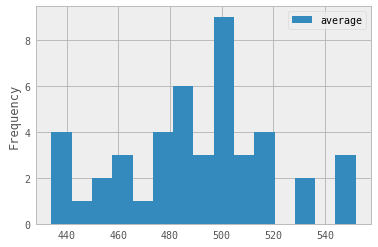

In [38]:
li_se = []
for f in files:
    li_se.append(pd.read_csv(f, header=None))

df  = pd.concat(li_se)
df.columns = ['average']
df.index = range(len(df))
df.index.name = 'chunk no'
df.info()

df.plot.hist(bins=15)


## Shutdown Engines

In [39]:
# rc.shutdown(targets='all', hub=True, block=True)